**Fortaleza**

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np

from statistics import mean

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.SpedDB
collection = db.tweets_brasil

In [3]:
city = 'Fortaleza'
df = pd.DataFrame.from_records(collection.find({'lang': {'$ne':'und'}, 'city':city, 'score': {'$ne':None}, 'polarity': {'$ne':None}, '$or':[{'geo_source':'place'}, {'geo_source':'user_location'}]}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'polarity':1,'_id': 0}).sort('created_at'))

In [4]:
len(df)

8199

In [ ]:
df.to_excel(city+'.xlsx')

In [5]:
df.head()

,created_at,geo_source,state,city,text,score,lang,polarity
0,2020-02-01 10:08:44,user_location,Ceará,Fortaleza,RT @ABC: LOCKDOWN: Haunting drone footage show...,-0.4404,en,-0.589889
1,2020-02-02 03:12:20,user_location,Ceará,Fortaleza,RT @spectatorindex: BREAKING: First coronaviru...,-0.5994,en,-0.440800
2,2020-02-02 10:26:27,user_location,Ceará,Fortaleza,RT @spectatorindex: BREAKING: First coronaviru...,-0.5994,en,-0.440800
3,2020-02-02 11:16:39,user_location,Ceará,Fortaleza,RT @LeiaJaOnline: A notícia do falecimento foi...,-0.5994,pt,-0.066250
4,2020-02-02 12:14:23,user_location,Ceará,Fortaleza,RT @gazetadopovo: Primeira morte por coronavír...,-0.5994,pt,-0.568250


Média total de sentimentos - Vader

In [6]:
df['score'].describe()

count    8199.000000
mean       -0.052540
std         0.465952
min        -0.986000
25%        -0.440400
50%         0.000000
75%         0.318200
max         0.980900
Name: score, dtype: float64

Média total de sentimentos - SenticNet

In [7]:
df['polarity'].describe()

count    8199.000000
mean        0.157835
std         0.301036
min        -0.990000
25%        -0.014491
50%         0.159667
75%         0.348708
max         1.000000
Name: polarity, dtype: float64

Tweets por língua

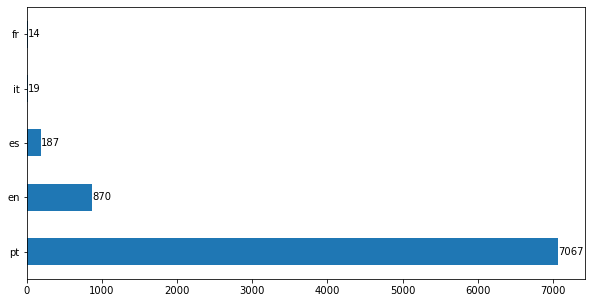

In [8]:
df.lang.value_counts()[:5].plot(kind='barh', figsize=(10, 5))

for index, value in enumerate(df.lang.value_counts()[:5]):
    plt.text(value, index, str(value), verticalalignment='center')

In [ ]:
import nltk
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')

## função para geração de nuvens de palavras a partir de uma lista de strings
def generate_word_cloud(words_list, lower_case):
    
    if (len(words_list) > 0):   
        words=""

        # Criando string a partir das palavras        
        for word in words_list:
            if (lower_case):
                words = words + ' ' + word.lower()
            else:
                words = words + ' ' + word
                
        ## configurando stopwords para desconsiderar partículas verbais (exemplo: voltando-me)  
        stopwords = set(STOPWORDS)
        stopwords.update(nltk.corpus.stopwords.words('portuguese'))
        stopwords.update(['t','https','http','co','rt','...','pra','pro','vc','pq','q','contra','tudo','covid','corona','coronavirus','coronavírus','coronavíru','coronaviru','víru','viru'])
        
        wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(words)

        plt.figure(figsize=(8,4))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

In [ ]:
words = list(df['text'])
generate_word_cloud(words, True)

In [ ]:
boxplot = df.boxplot(column=['score', 'polarity'], grid=True, figsize=(9, 5))

In [ ]:
# Calculando coeficiente de correlação entre score e polarity (método de Pearson)
df['score'].corr(df['polarity'])

Funções auxiliares

In [73]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, column):

    date_set = set()  
    
    for item in df.created_at:
        date = datetime.datetime(item.year, item.month, item.day)
        date_set.add(date)
    
    # Listas utilizadas para montagem do df
    date_list = list(date_set)
    date_list.sort()
    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        # Média de scores do período
        score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
        score_mean_list.append(score_mean)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [10]:
# Função para geração de gráficos
def generate_graphic(x, y, label, color, xLabel, yLabel, title):
         
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y,color=color, linestyle='solid', linewidth=2,label=label)
    
    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [11]:
# Função para gerar um gráfico X outro
def generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title):
      
    plt.rcParams['figure.figsize'] = (18,5)
    plt.plot(x,y1,color=color1, linestyle='solid', linewidth=2,label=label1)
    plt.plot(x,y2,color=color2, linestyle='solid', linewidth=2,label=label2)

    plt.xticks(x, rotation=80)
    plt.legend(fontsize=15)
    plt.xlabel(xLabel,fontsize=15)
    plt.ylabel(yLabel,fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [12]:
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

Média de sentimentos por dia - Vader x SenticNet

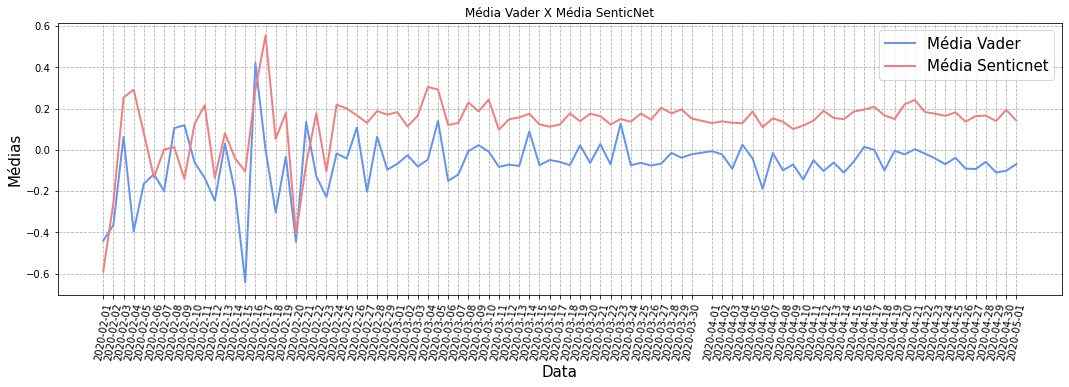

In [13]:
df1 = building_dates_df(df, 'score')
df2 = building_dates_df(df, 'polarity')

x = df1.created_at
y1 = df1.score_mean
y2 = df2.polarity_mean

label1 = 'Média Vader'
label2 = 'Média Senticnet'

color1 = 'cornflowerblue'
color2 = 'lightcoral'

xLabel = 'Data'
yLabel = 'Médias'

title = 'Média Vader X Média SenticNet'

generate_vs_graphic(x, y1, y2, label1, label2, color1, color2, xLabel, yLabel, title)

Análises por período

In [14]:
# Carregando arquivo CSV contendo casos de covid 19 do Brasil
file = '/home/mario/Documentos/LCDIA/Analytics/Datasets/caso_full.csv'
df_cases_brasil = pd.read_csv(file, usecols=['city', 'state', 'date', 'new_confirmed', 'new_deaths','last_available_confirmed','last_available_deaths','last_available_confirmed_per_100k_inhabitants','last_available_death_rate'])

In [ ]:
# Selecionando casos da cidade analisada
df_cases_city = df_cases_brasil.query('city == "'+city+'"')
df_cases_city = df_cases_city.reset_index()
df_cases_city.head()

In [ ]:
# Data do primeiro caso 
first_case_date = df_cases_city.loc[0, 'date']
print(first_case_date)

In [ ]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

In [ ]:
# Data da primeira morte
result = df_cases_city.query('last_available_deaths != "0"')
first_death_date = df_cases_city.loc[min(result.index), 'date']
print(first_death_date)

Períodos:

- Sem casos: 01/02/2020 a 15/03/2020
- Data do primeiro caso: 16/03/2020 a 19/03/2020
- Data do primeiro decreto de medidas restritivas (Governo Estadual): 20/03/2020

**Análises por Períodos**

**Média de sentimentos no primeiro intervalo**

In [ ]:
df_periodo1 = df.query('created_at >= "2020-02-01 00:00:00" and created_at <= "2020-03-15 23:59:59"')
len(df_periodo1)

**Média de sentimentos no segundo intervalo**

In [ ]:
df_periodo2 = df.query('created_at >= "2020-03-16 00:00:00" and created_at <= "2020-03-19 23:59:59"')
len(df_periodo2)

**Média de sentimentos no terceiro intervalo**

In [ ]:
df_periodo3 = df.query('created_at >= "2020-03-20 00:00:00" and created_at <= "2020-05-01 23:59:59"')
len(df_periodo3)

Gráfico - Média Valores

In [ ]:
labels = ['Sem Casos', 'Após 1º caso', 'Após Medidas Restritivas']
y1 = [mean(df_periodo1['score']), mean(df_periodo2['score']), mean(df_periodo3['score'])]
y2 = [mean(df_periodo1['polarity']), mean(df_periodo2['polarity']), mean(df_periodo3['polarity'])]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, y1, width, label='Vader', color='cornflowerblue')
rects2 = ax.bar(x + width/2, y2, width, label='SenticNet', color='lightcoral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Média de Sentimentos')
ax.set_title('Média de Sentimentos por Período')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

***
**Correlações entre médias de sentimentos e registros de casos de Covid-19**

In [122]:
def populate_initial_dates(df_cases_city):
    
    from datetime import datetime, date, timedelta

    # Data inicial dos registros
    start_date = date(2020,2,1)

    # Data do primeiro caso
    first_case_str = df_cases_city.loc[0, 'date']
    first_case_date = datetime.strptime(first_case_str, '%Y-%m-%d').date()

    dates = pd.date_range(start_date, first_case_date-timedelta(days=1), freq='d')
    dates = dates.to_pydatetime()

    df_initial = pd.DataFrame(columns=list(df_cases_city.columns))

    for index in range(len(dates)):
        date_str = dates[index].strftime('%Y-%m-%d')
        df_initial.loc[index] = [city, date_str, 0, 0, 0, 0, state_code, 0, 0]
        #date = datetime.strptime(date_str, '%Y-%m-%d')
        #df_initial.loc[index] = [city, dates[index], 0, 0, 0, 0, state_code, 0, 0]

    df_result = pd.concat([df_initial, df_cases_city], ignore_index=True)
    
    return df_result;

In [118]:
# Função para retornar todos os casos de uma cidade
def filter_cases_city (df_cases_brasil, city, state_code):
    
    # Selecionando casos de Covid da cidade 
    # df_cases_city = df_cases_brasil.loc[(df_cases_brasil['city'] == city) & (df_cases_brasil['state'] == state_code) & (df_cases_brasil['date'] < '2020-05-02')]
    
    df_cases_city = df_cases_brasil.query('city == "'+city+'" and date <= "2020-05-01 23:59:59"')
    df_cases_city = df_cases_city.reset_index(drop=True)
    
    # Populando dataframe com datas iniciais (antes dos casos de Covid)
    df_cases_city = populate_initial_dates(df_cases_city)
    
    return df_cases_city

In [119]:
# Realizando o merge do dataframe de scores x dataframe de casos
def merge_dfs(df_scores_city, df_cases_city):

    # Padronizando as colunas de datas
    df_scores_city = df_scores_city.rename(columns={'created_at':'date'})

    # Convertendo as colunas de datas para o mesmo tipo de objeto
    df_scores_city = df_scores_city.astype({'date': str})
    df_cases_city = df_cases_city.astype({'date': str})

    # Realizando merges para recuperar período de datas em comum
    return pd.merge(df_scores_city, df_cases_city, on='date', how='inner')

In [120]:
def prepare_data(df_cases, df_tweets, city, state, state_code, column):
    
    # Filtrando registros de casos de Covid
    df_cases_city = filter_cases_city(df_cases, city, state_code)

    # Montando dataframe com a média de scores de sentimentos por data (existe uma data sem dados)
    df_scores_city = building_dates_df(df_tweets, column)
    #print(df_scores_city.shape[0])

    # Realizando o merge dos dataframes de média de scores x dataframe de casos
    df_merged = merge_dfs(df_scores_city, df_cases_city)
    #print(df_merged.shape[0])

    # Criando atributos derivados
    df_merged = create_attributes(df_merged)
    
    return df_merged

In [121]:
## Cálculo do percentual de crescimento de um valor no tempo
def calculate_percent(df, column, new_column):  
    
    values_list = []
    
    is_first = True
    last_value = 0
    
    for (i, row) in df.iterrows():
        if (is_first == True):
            is_first = False
            last_value = row[column]
            values_list.append(0)
        else:
            try:
                percent = 100 * (((row[column] - last_value))/last_value)
                percent = round(percent, 2)
                values_list.append(percent)
                last_value = row[column]
            except ZeroDivisionError:
                values_list.append(0)
                last_value = row[column]
            
    df[new_column] = pd.Series(values_list, index = df.index)
    
    return df

In [123]:
# Função para derivar novos atributos
def create_attributes(df_merged):
    
    # Somando colunas new_confirmed + new_deaths (notícias ruins do dia)
    df_merged['bad_news'] = df_merged['new_confirmed'] + df_merged['new_deaths']

    # Somando colunas last_available_confirmed + last_available_deaths (notícias ruins totais)
    df_merged['last_bad_news'] = df_merged['last_available_confirmed'] + df_merged['last_available_deaths']

    # Calculando percentual de crescimento de score de sentimento em relação ao dia anterior
    # df_merged = calculate_percent(df_merged, 'score_mean', 'score_mean_pct')

    # Calculando percentual de crescimento diário de novos casos em relação ao dia anterior
    df_merged = calculate_percent(df_merged, 'new_confirmed', 'new_confirmed_pct')

    # Calculando percentual de crescimento diário de novas mortes em relação ao dia anterior
    df_merged = calculate_percent(df_merged, 'new_deaths', 'new_deaths_pct')

    # Calculando percentual de crescimento diário de novos casos em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_confirmed', 'last_available_confirmed_pct')

    # Calculando percentual de crescimento diário de novas mortes em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_deaths', 'last_available_deaths_pct')

    # Calculando percentual de crescimento diário de novas mortes por 100k habitantes em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_confirmed_per_100k_inhabitants', 'last_available_confirmed_per_100k_inhabitants_pct')

    # Calculando percentual de crescimento diário da taxa de mortalidade em relação ao total
    df_merged = calculate_percent(df_merged, 'last_available_death_rate', 'last_available_death_rate_pct')

    # Calculando percentual de crescimento de notícias ruins em relação ao dia anterior
    df_merged = calculate_percent(df_merged, 'bad_news', 'bad_news_pct')

    # Calculando percentual de crescimento de notícias ruins em relação ao total
    df_merged = calculate_percent(df_merged, 'last_bad_news', 'last_bad_news_pct')
    
    return df_merged;

In [124]:
state_code = 'CE'
state = 'Ceará'

Correlações Vader

In [130]:
column = 'score'
df_merged = prepare_data(df_cases_brasil, df, city, state, state_code, column)

target_column = 'score_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False)

score_mean                                           1.000000
last_available_confirmed_per_100k_inhabitants_pct    0.045233
last_available_confirmed_pct                         0.045233
last_bad_news_pct                                    0.044725
new_deaths_pct                                       0.039727
new_confirmed_pct                                    0.020547
bad_news_pct                                         0.017690
last_available_deaths_pct                            0.008567
last_available_death_rate_pct                       -0.032364
Name: score_mean, dtype: float64

In [131]:
df_merged

,date,score_mean,city,last_available_confirmed,last_available_confirmed_per_100k_inhabitants,last_available_death_rate,last_available_deaths,state,new_confirmed,new_deaths,bad_news,last_bad_news,new_confirmed_pct,new_deaths_pct,last_available_confirmed_pct,last_available_deaths_pct,last_available_confirmed_per_100k_inhabitants_pct,last_available_death_rate_pct,bad_news_pct,last_bad_news_pct
0,2020-02-01,-0.440400,Fortaleza,0,0,0,0,CE,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2020-02-02,-0.364930,Fortaleza,0,0,0,0,CE,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2020-02-03,0.062950,Fortaleza,0,0,0,0,CE,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,2020-02-04,-0.395986,Fortaleza,0,0,0,0,CE,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,2020-02-05,-0.164643,Fortaleza,0,0,0,0,CE,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-04-27,-0.092864,Fortaleza,5326,198.242,0.0593,316,CE,335,21,356,5642,-25.56,-41.67,6.71,7.12,6.71,0.34,-26.75,6.73
86,2020-04-28,-0.058427,Fortaleza,5481,204.012,0.06,329,CE,155,13,168,5810,-53.73,-38.10,2.91,4.11,2.91,1.18,-52.81,2.98
87,2020-04-29,-0.109883,Fortaleza,5712,212.61,0.0611,349,CE,231,20,251,6061,49.03,53.85,4.21,6.08,4.21,1.83,49.40,4.32
88,2020-04-30,-0.101332,Fortaleza,5970,222.213,0.0638,381,CE,258,32,290,6351,11.69,60.00,4.52,9.17,4.52,4.42,15.54,4.78


Correlações SenticNet

In [128]:
column = 'polarity'
df_merged = prepare_data(df_cases_brasil, df, city, state, state_code, column)

target_column = 'polarity_mean'
corr_matrix = df_merged.corr()
corr_matrix[target_column].sort_values(ascending=False)

polarity_mean                                        1.000000
last_bad_news_pct                                    0.084575
last_available_confirmed_per_100k_inhabitants_pct    0.084111
last_available_confirmed_pct                         0.084111
last_available_deaths_pct                            0.083268
bad_news_pct                                         0.064987
new_confirmed_pct                                    0.064341
new_deaths_pct                                       0.060076
last_available_death_rate_pct                        0.017482
Name: polarity_mean, dtype: float64

Fontes:
-  Decretos do Governo do Ceará com ações contra o coronavírus - https://www.ceara.gov.br/decretos-do-governo-do-ceara-com-acoes-contra-o-coronavirus/
- CoronaVírus - https://coronavirus.ceara.gov.br/project_tag/decreto/